2024-09-20 22:00:13,154 - INFO - Available Memory: 1.64 GB


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.6476 - val_loss: 0.5090
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.3431 - val_loss: 0.1367
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.1886 - val_loss: 0.0952
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.1183 - val_loss: 0.0525
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0662 - val_loss: 0.0225
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0287 - val_loss: 0.0058
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0091 - val_loss: 0.0019
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0039 - val_loss: 0.0019
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0032 - val_loss: 0.0021
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0029 - val_loss: 0.0018


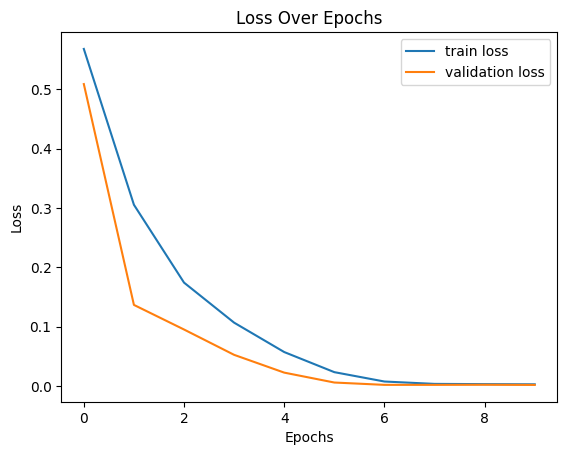

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


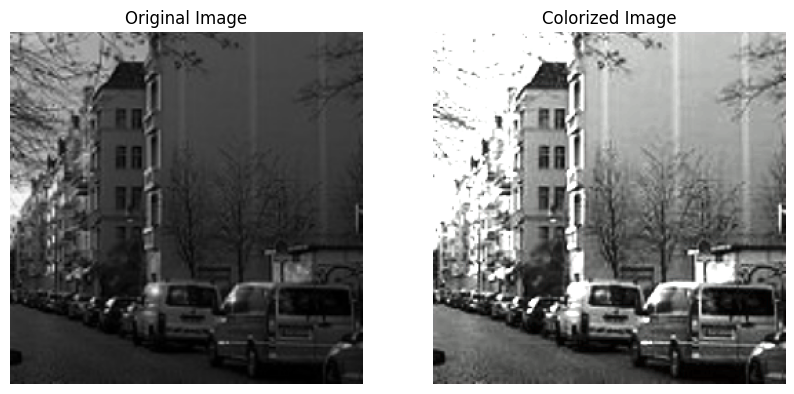

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Input, UpSampling2D, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import psutil
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Memory check
available_memory = psutil.virtual_memory().available / (1024 ** 3)  # Convert to GB
logging.info(f"Available Memory: {available_memory:.2f} GB")

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (256, 256))  # Resize image to 256x256
    return image

# Function to convert RGB image to LAB format
def convert_to_lab(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    return l_channel, np.stack((a_channel, b_channel), axis=-1)

# Function to create the colorization model
def create_colorization_model():
    model = Sequential()
    model.add(Input(shape=(256, 256, 1)))  # Input shape for grayscale images
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(UpSampling2D(size=(2, 2)))  # Return back to 256x256
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(UpSampling2D(size=(2, 2)))  # Maintain same size (not double)
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))  # Output shape for AB channels

    model.compile(optimizer=Adam(), loss='mse')
    return model

# Function to predict and colorize
def predict_and_colorize(model, grayscale_image):
    # Add batch dimension
    grayscale_image = grayscale_image.reshape(1, 256, 256, 1)
    predicted_ab = model.predict(grayscale_image)[0]
    
    # Combine the L channel with the predicted AB channels
    l_channel = grayscale_image[0, :, :, 0]
    l_channel = np.expand_dims(l_channel, axis=-1)
    predicted_lab = np.concatenate((l_channel, predicted_ab), axis=-1)
    
    # Convert LAB back to RGB
    predicted_rgb = cv2.cvtColor(predicted_lab, cv2.COLOR_LAB2RGB)
    return predicted_rgb

# Load grayscale images
gray_image_path = r'C:\Users\visha\OneDrive\Desktop\Image COLORIZATION\archive\landscape Images\gray' 
# note : this path folder used by me please update your path acc. to you 
image_files = [f for f in os.listdir(gray_image_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(image_files) == 0:
    logging.error("No images found in the specified folder.")
else:
    # Load and preprocess images for training
    grayscale_images = []
    ab_channels = []

    for file in image_files[:100]:  # Limiting to first 100 images to avoid memory issues
        image_path = os.path.join(gray_image_path, file)
        rgb_image = load_and_preprocess_image(image_path)
        l_channel, ab = convert_to_lab(rgb_image)
        
        # Store images for training
        grayscale_images.append(l_channel)
        ab_channels.append(ab)

    # Convert lists to numpy arrays
    grayscale_images = np.array(grayscale_images) / 255.0  # Normalize
    ab_channels = np.array(ab_channels) / 255.0  # Normalize

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(grayscale_images, ab_channels, test_size=0.2, random_state=42)

    # Create and train the model
    model = create_colorization_model()
    history = model.fit(X_train.reshape(-1, 256, 256, 1), y_train, 
                        validation_data=(X_val.reshape(-1, 256, 256, 1), y_val), 
                        epochs=10, batch_size=8)

    # Loss observation
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test with the first image
    test_image_path = os.path.join(gray_image_path, image_files[0])
    test_rgb_image = load_and_preprocess_image(test_image_path)
    test_l_channel, _ = convert_to_lab(test_rgb_image)

    # Predict colorization
    predicted_colorized_image = predict_and_colorize(model, test_l_channel)

    # Display the original and colorized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_rgb_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_colorized_image)
    plt.title("Colorized Image")
    plt.axis('off')
    plt.show()